man lernt
* screenscraping in der wikipedia (vertrautheit mit HTML hilfreich, aber keine voraussetzung)
* erzeugung von tabularen daten aus wenig strukturierten inhalten der Wikipedia
* was ist eine prozedur/methode
* netzwerkanalyse
* export data to visualize it in a "normal" website using the D3.js library

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import networkx as nx # network analysis
import itertools
from datetime import datetime # for time measurement
import sys
import os

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
!pip install wikipedia

You will find the documentation of the Wikipedia package [_here_](https://pypi.python.org/pypi/wikipedia).

In [3]:
import wikipedia as wiki

no longer needed?

In [4]:
#!pip install html2text

no longer needed?

In [5]:
#import xml.etree.ElementTree as ET
#import html2text 

In [6]:
page = wiki.page("batman")
#page = wiki.page("catwoman")

Anaconda comes with _Beautiful Soup_, a library for screen-scraping [documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/)

In [7]:
#from bs4 import BeautifulSoup

# Beautiful Soup needs the HTML of the Wikipedia page
#html_doc=page.html()
#soup = BeautifulSoup(html_doc, 'html.parser')
#print(soup.prettify())

In [8]:
#tables=soup.find_all('table',class_="infobox")
#infoboxTable=tables[0] # fill fail if no infobox is presented, will be fixed later
#print infoboxTable.prettify()

we expect the following _th_ elements as seperators
* <th scope="row" style="width: 40%;">Alter ego</th>
* <th scope="row" style="width: 40%;">Team affiliations</th>
* <th scope="row" style="width: 40%;">Partnerships</th>
* <th scope="row" style="width: 40%;">Notable aliases</th>
* <th scope="row" style="width: 40%;">Abilities</th>

In [9]:
#rows=infoboxTable.find_all("tr")
#for row in rows:
#    if row.th is not None:
#        print row.th.string

More on [_regular expressions_](https://docs.python.org/2/howto/regex.html)

In [10]:
#abilityRow=None
#partnerRow=None
#firstAppearance=""
#p = re.compile('\d\d\d\d') # we expect the year to have four digits

#for row in rows:
#    if row.th is not None and row.th.string == "First appearance":
#        rawText=row.td.get_text()
#        m = p.search(rawText)
#        firstAppearance=m.group()
#    elif row.th is not None and row.th.string == "Abilities":
#        abilityRow=row
#    elif row.th is not None and row.th.string == "Partnerships":
#        partnerRow=row

In [11]:
# as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
#abilities=[]
#if abilityRow is not None:
#    li=abilityRow.find_all("li")
#    for l in li:
        # check if an anchor (a link to a website) is contained
#        if l.a is not None:
            # if so, discard the link and keep the plain text
#            l.a.unwrap()
#        abilities.append(l.get_text().strip())
        

In [12]:
#partnerships=[]
#if partnerRow is not None:
#    partners=partnerRow.find_all("a")
#    for p in partners:
#        partnerships.append(p.string)

In [13]:
#for a in abilities:
#    print a

In [14]:
#for p in partnerships:
#    print p

In [15]:
#print firstAppearance

now, we will define a procedure/sub-routine for later usage


In [16]:
def extractData(myDoc):
    soup = BeautifulSoup(myDoc, 'html.parser')
    #print soup.title
    tables=soup.find_all('table',class_="infobox")
    # if there is no infobox, ignore the page
    if len(tables)>=1:
        infoboxTable=tables[0]
        # try to get the name of the character
        if infoboxTable.tr.th is not None:
            name=infoboxTable.tr.th.get_text()
        else:
            name="N/A"
        abilityRow=None
        partnerRow=None
        firstAppearance="2020" # dummy entry in case the "first appearance" entry is missing
        abilities=[]
        partnerships=[]
        
        # image processing
        if infoboxTable.find('img'):
            articleImage=infoboxTable.find('img')["src"]
        else:
            articleImage=None

        p = re.compile('\d\d\d\d') # we expect the year of first appearance to have four digits
        
        rows=infoboxTable.find_all("tr")
        for row in rows:
            if row.th is not None and row.th.string == "First appearance":
                rawText=row.td.get_text()
                m = p.search(rawText)
                # deal with missing years of first appearance
                if m:
                    firstAppearance=m.group()
            elif row.th is not None and row.th.string == "Abilities":
                abilityRow=row
            elif row.th is not None and row.th.string == "Partnerships":
                partnerRow=row

        # as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
        if abilityRow is not None:
            li=abilityRow.find_all("li")
            for l in li:
                # check if an anchor (a link to a website) is contained
                if l.a is not None:
                    # if so, discard the link and keep the plain text
                    l.a.unwrap()
                abilities.append(l.get_text().strip())
        # a fix for abilities without the ul/li structure
            if len(li)==0:
                rawStr=str(abilityRow.td)
                rawStr=rawStr.replace("<td>","").replace("</td>","").replace("\n","").strip()
                # abilities are sometimes separated by  <br/>, a comma, a period, or "and"
                rawStr=rawStr.replace("<br/>",";")
                rawStr=rawStr.replace(",",";")
                rawStr=rawStr.replace(".",";")
                # we have to treat 'and' in a special way as it may be contained as a substring in "normal" words
                #rawStr=rawStr.replace("and",";")
                rawTokens=rawStr.split(" and ")
                rawStr=";".join(rawTokens)
                # remove all other HTML tags
                p2 = re.compile(r'<.*?>')
                rawStr=p2.sub(' ', rawStr)
                # clean whitespaces surrounding the string
                rawStr.strip()
                rawTokens=rawStr.split(";")
                for t in rawTokens:
                    t=t.strip()
                    # we have to ignore additional noise such as the following "abilities"
                    if t.lower()=="see below":
                        pass
                    elif t.lower()=="various":
                        pass
                    elif t.lower()=="varies":
                        pass
                    elif t.lower()=="none":
                        pass
                    else:
                        if str(t):
                            abilities.append(str(t))

        if partnerRow is not None:
            partners=partnerRow.find_all("a")
            for p in partners:
                partnerships.append(p.string)

        
        
        result=dict()
        result["name"]=name
        result["firstAppearance"]=int(firstAppearance)
        result["abilities"]=abilities
        result["abilitiesCount"]=len(abilities)
        result["partnerships"]=partnerships
        result["partnershipsCount"]=len(partnerships)
        if articleImage:
            result["imageURL"]="https:"+str(articleImage)
        else:
            result["imageURL"]="https://None"
        #print abilities
        return result
    else:
        return None

### Debug

In [17]:
html_doc=urllib.urlopen("https://en.wikipedia.org/wiki/El_Diablo_(comics)")
r=extractData(html_doc)
print r

print "\n NEXT\n"

html_doc=urllib.urlopen("https://en.wikipedia.org/wiki/Batman")
r=extractData(html_doc)
print r

{'partnershipsCount': 0, 'abilities': ['(Sandoval)', 'Olympic level boxer', 'athlete', '(Santana)', 'Pyrokinesis'], 'name': u'El Diablo', 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/d/d7/El_Diablo_comic_book_cover_%28vol._2_no._16%29.jpg', 'abilitiesCount': 5, 'firstAppearance': 1970, 'partnerships': []}

 NEXT

{'partnershipsCount': 8, 'abilities': [u'Genius-level intellect', u'Peak human physical and mental condition', u'Master martial artist and hand-to-hand combatant', u'Master detective', u'Utilizes high-tech equipment and weapons'], 'name': u'Batman', 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/7/75/Comic_Art_-_Batman_by_Jim_Lee_%282002%29.png/250px-Comic_Art_-_Batman_by_Jim_Lee_%282002%29.png', 'abilitiesCount': 5, 'firstAppearance': 1939, 'partnerships': [u'Robin', u'Batgirl', u'Nightwing', u'James "Jim" Gordon', u'Catwoman', u'Superman', u'Wonder Woman', u'Green Arrow']}


methodenaufruf erklären

In [18]:
r=extractData(html_doc)

In [19]:
print r

None


In [20]:
page.categories

[u'1939 comics debuts',
 u'Action heroes',
 u'American culture',
 u'Articles with DMOZ links',
 u'Batman',
 u'Character pop',
 u'Characters created by Bill Finger',
 u'Characters created by Bob Kane',
 u'Comic book publication histories',
 u'Comics adapted into animated series',
 u'Comics adapted into films',
 u'Comics adapted into plays',
 u'Comics adapted into radio series',
 u'Comics adapted into television series',
 u'Comics adapted into video games',
 u'Comics characters introduced in 1939',
 u'Comics navigational boxes purge',
 u'Converted category character infoboxes',
 u'Converted comics character infoboxes',
 u'DC Comics martial artists',
 u'DC Comics superheroes',
 u'DC Comics television characters',
 u'Featured articles',
 u'Fictional American people of Scottish descent',
 u'Fictional antiheroes',
 u'Fictional aviators',
 u'Fictional businesspeople',
 u'Fictional criminologists',
 u'Fictional detectives',
 u'Fictional engineers',
 u'Fictional escapologists',
 u'Fictional for

In [21]:
page=wiki.page("Category:DC_Comics_superheroes")

In [22]:
categoryPages=[]
# DC superheroes
categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pageuntil=Dragon+King%0ADragon+King+%28DC+Comics%29#mw-pages")
categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Krypto#mw-pages")
categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Robin%0ARobin+%28comics%29#mw-pages")
categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=XS+%28comics%29#mw-pages")

# general DC characters
#categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pageuntil=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
#categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pagefrom=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")

```
<div id="mw-pages">
```
wird gesucht

In [23]:
def getSuperheroes(myCategories,myDictionary):
    for c in myCategories:
    # ignore <a class="mw-redirect"> as they redirect into articles, 
    # to be precise, we only consider <a> tags without a class atrribute 
    # because we are only interested in superheroes with distinct wikipedia articles
        items=c.ul.find_all("li")
        for item in items:
            if item.a.get("class") is None:
                myDictionary[item.a["title"]]=item.a["href"]

In [24]:
startTime=datetime.now()
print "Fetching superhero URLs..."
sys.stdout.flush() # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print

superheroes=OrderedDict() # we use an ordered dict here because we want to preserve the order items were added
for catPage in categoryPages:
    html_doc=urllib.urlopen(catPage)
    soup = BeautifulSoup(html_doc, 'html.parser')
    categories=soup.select("#mw-pages")[0].select(".mw-category-group")
    getSuperheroes(categories,superheroes) # we pass the superheroes dictionary on to merge the heroes extracted from all pages

duration=datetime.now()-startTime
print "Processing completed in "+str(duration)+"."

Fetching superhero URLs...
Processing completed in 0:00:02.565007.


checken, da ursprünglich characters abgefragt wurden: __Relationship of Clark Kent and Lois Lane__ is obviously no superhero but we have to deal with it later

## Wrap Things Up

the processing will take a while, i.e., 3-4 minutes on my notebook

In [25]:
wikiBaseURL="https://en.wikipedia.org"
heroFeats=[]
i=0;
countItems=len(superheroes)

print "Processing "+str(countItems)+" Wikipedia pages and downloading images. This will take a while..."
sys.stdout.flush() # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print

startTime=datetime.now()


for key, value in superheroes.iteritems():
    i=i+1
    wikiURL=wikiBaseURL+value
    #print "Processing "+wikiURL+" ; "+str(i)+" of "+str(countItems)
    html_doc=urllib.urlopen(wikiURL)
    r=extractData(html_doc)
    if r:
        r["url"]=wikiURL
        heroFeats.append(r)
    else:
        print "\t"+wikiURL+" does not contain an infobox. Processing aborted."

duration=datetime.now()-startTime
print "Processing completed in "+str(duration)+"."

Processing 572 Wikipedia pages and downloading images. This will take a while...
	https://en.wikipedia.org/wiki/Lady_Luck_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Manticore_(DC_Comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Miss_Fear_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Nuklon does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Omni_(DC_Comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Protector_(DC_Comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Redwing_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Skyman does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Star-Spangled_Kid does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/List_of_Static_enemi

the download takes approx. 2 minutes

In [26]:
print "Downloading images. This will take a while..."
sys.stdout.flush() # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print

startTime=datetime.now()
# downloading images
imagePath="./img.dc_chars/"

if not os.path.exists(imagePath):
    os.makedirs(imagePath)

for i,hero in enumerate(heroFeats):
    hero["localFilePath"]="N/A" # caveat wg. JSON http://stackoverflow.com/questions/13715891/d3-json-uncaught-typeerror-cannot-read-property-children-of-undefined
    iURL=hero["imageURL"]
    if not iURL=="https://None":
        tokens=iURL.split(".")
        suffix=tokens[-1]
        localFilePath=imagePath+str(i)+"."+suffix
        hero["localFilePath"]=localFilePath
        try:
            urllib.urlretrieve(iURL,localFilePath)
        except IOError: # if we would catch all other exception, we would have a hard time to stop the kernel at all
            print "Downloading error while accessing: "+hero["imageURL"]
duration=datetime.now()-startTime
print "Downloading completed in "+str(duration)+"."

as the processing took a while, it would be handy to save the result, in order to do so, we will create a pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) out of the data

In [27]:
rows=[]
columns=["Name","Year","Abilities","AbilitiesCount","Partnerships","PartnershipsCount","URL","ImageURL","localFilePath"]

for hero in heroFeats:
    rowx=[]
    rowx.append(hero["name"])
    rowx.append(hero["firstAppearance"])
    rowx.append(",".join(hero["abilities"]))
    rowx.append(hero["abilitiesCount"])
    rowx.append(",".join(hero["partnerships"]))
    rowx.append(hero["partnershipsCount"])
    rowx.append(hero["url"])
    rowx.append(hero["imageURL"])
    rowx.append(hero["localFilePath"])
    rows.append(rowx)

df=pd.DataFrame(rows,columns=columns)
df

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,#711,1941,Accomplished hand to hand combatant,1,,0,https://en.wikipedia.org/wiki/711_(Quality_Com...,https://None,N/A
1,Abin Sur,1959,Green Lantern power ring,1,,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/1.jpg
2,Access,1996,"Cross-dimensional awareness,Dimensional transp...",4,,0,https://en.wikipedia.org/wiki/Access_(comics),https://upload.wikimedia.org/wikipedia/en/8/8c...,./img.dc_chars/2.jpg
3,Acrata,2000,"Shadow teleportation,martial arts",2,"El Muerto,Iman",2,https://en.wikipedia.org/wiki/Acrata,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/3.jpg
4,Agent Liberty,1991,"Special suit that provide weaponry,forcefield,...",3,,0,https://en.wikipedia.org/wiki/Agent_Liberty,https://upload.wikimedia.org/wikipedia/en/6/69...,./img.dc_chars/4.png
5,Air Wave,1942,,0,,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/5.jpg
6,Bart Allen,1994,"Superhuman speed, stamina and durability,photo...",6,"Barry Allen,Wally West,Jay Garrick",3,https://en.wikipedia.org/wiki/Bart_Allen,https://upload.wikimedia.org/wikipedia/en/d/d6...,./img.dc_chars/6.jpg
7,Crispus Allen,2000,,0,,0,https://en.wikipedia.org/wiki/Crispus_Allen,https://upload.wikimedia.org/wikipedia/en/0/0b...,./img.dc_chars/7.PNG
8,Alley-Kat-Abra,1982,"Expert martial artist,Via Magic Wanda :,Levita...",8,,0,https://en.wikipedia.org/wiki/Alley-Kat-Abra,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/8.jpg
9,Gim Allon,1960,"As Colossal Boy,Leviathan :,Expand his body to...",7,,0,https://en.wikipedia.org/wiki/Gim_Allon,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/9.png


to save it to disk, a CSV file is a possible solution; ? operator erklären

In [28]:
#df.to_csv?

we have to pass the encoding parameter as our data frame contains Unicode data, "\t" as separator because of the commas we used to separate the abilities etc.

In [29]:
df.to_csv('dc_superheroes.csv',index=False,header=True,encoding='utf-8', sep="\t")

# Continuing the Analysis
later, we could read the data again with [read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)

In [30]:
df=pd.read_csv('dc_superheroes.csv',encoding='utf-8', sep="\t",dtype={"Partnerships":'str'})
df.head()

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,#711,1941,Accomplished hand to hand combatant,1,NaN,0,https://en.wikipedia.org/wiki/711_(Quality_Com...,https://None,NaN
1,Abin Sur,1959,Green Lantern power ring,1,NaN,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/1.jpg
2,Access,1996,"Cross-dimensional awareness,Dimensional transp...",4,NaN,0,https://en.wikipedia.org/wiki/Access_(comics),https://upload.wikimedia.org/wikipedia/en/8/8c...,./img.dc_chars/2.jpg
3,Acrata,2000,"Shadow teleportation,martial arts",2,"El Muerto,Iman",2,https://en.wikipedia.org/wiki/Acrata,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/3.jpg
4,Agent Liberty,1991,"Special suit that provide weaponry,forcefield,...",3,NaN,0,https://en.wikipedia.org/wiki/Agent_Liberty,https://upload.wikimedia.org/wikipedia/en/6/69...,./img.dc_chars/4.png


In [31]:
# the "lonely" superheroes
df2=df[df["Partnerships"].isnull()]
df2.shape

(492, 9)

In [32]:
# the "sociable" superheroes
df3=df[df["Partnerships"].notnull()]
df3.shape

(65, 9)

In [33]:
df[df['Year']==df['Year'].min()]

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
361,Rima,1904,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Rima,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/361.jpg


In [34]:
df.describe()

,Year,AbilitiesCount,PartnershipsCount
count,557.000000,557.000000,557.000000
mean,1976.025135,3.890485,0.303411
std,23.513032,3.415032,1.125029
min,1904.000000,0.000000,0.000000
25%,1959.000000,1.000000,0.000000
50%,1980.000000,3.000000,0.000000
75%,1994.000000,5.000000,0.000000
max,2020.000000,23.000000,10.000000


apply-statement erklären

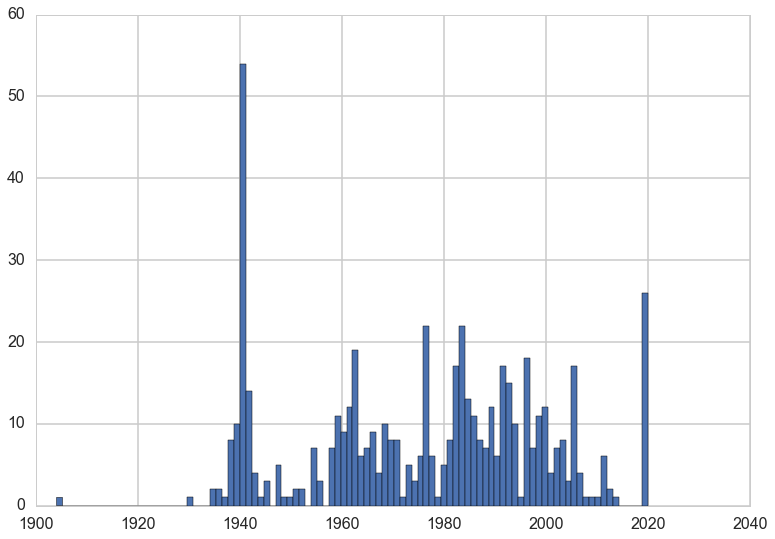

In [35]:
df['Year'].hist(bins=100)

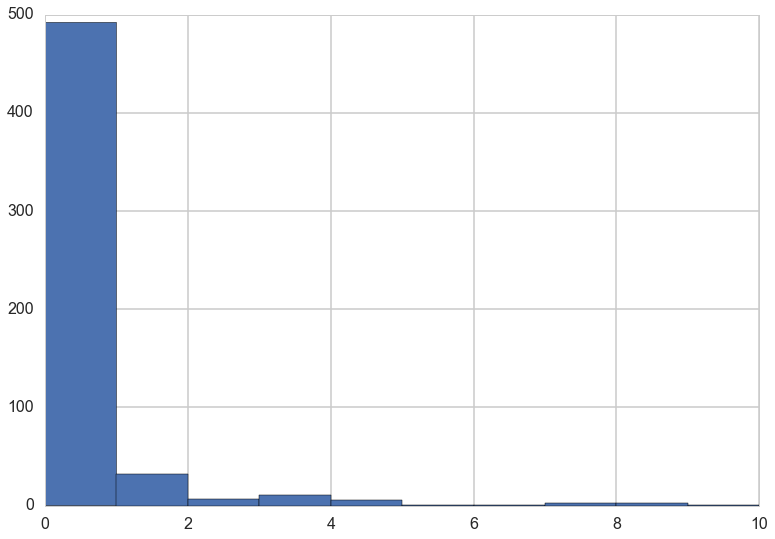

In [36]:
df['PartnershipsCount'].hist()

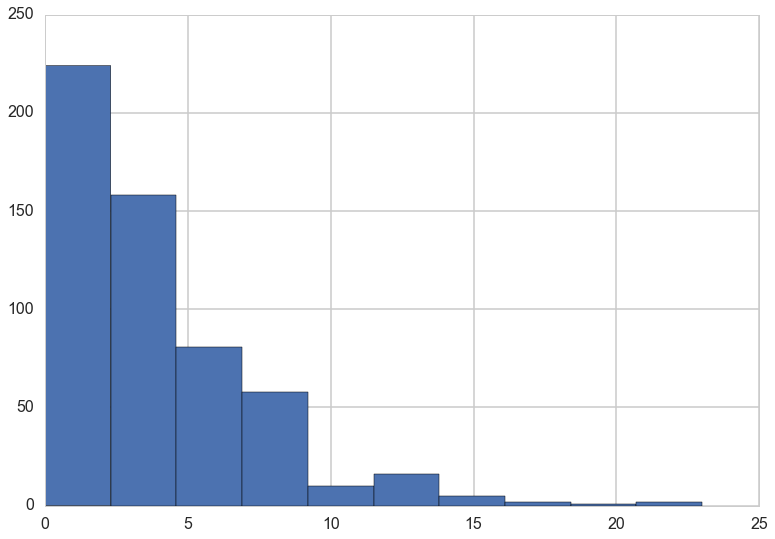

In [37]:
df['AbilitiesCount'].hist()

In [38]:
df[df['AbilitiesCount']==df['AbilitiesCount'].max()]

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
475,The Flash (Barry Allen),1956,Brilliant knowledge of chemistry\nCreator of t...,23,"Jay Garrick,Wally West,Bart Allen,Green Lanter...",7,https://en.wikipedia.org/wiki/Flash_(Barry_Allen),https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/475.jpg


In [39]:
df[df['AbilitiesCount']==1]

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,#711,1941,Accomplished hand to hand combatant,1,NaN,0,https://en.wikipedia.org/wiki/711_(Quality_Com...,https://None,NaN
1,Abin Sur,1959,Green Lantern power ring,1,NaN,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/1.jpg
13,Amethyst,1983,Magic,1,NaN,0,"https://en.wikipedia.org/wiki/Amethyst,_Prince...",https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/13.jpg
16,Animal Man,1965,Ability to gain the powers of any animal that ...,1,NaN,0,https://en.wikipedia.org/wiki/Animal_Man,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/16.png
30,Arisia Rrab,1981,Green Lantern Power Ring,1,NaN,0,https://en.wikipedia.org/wiki/Arisia_Rrab,https://upload.wikimedia.org/wikipedia/en/1/1c...,./img.dc_chars/30.JPG
32,Miss Arrowette,1960,Olympic-level archery skills,1,NaN,0,https://en.wikipedia.org/wiki/Arrowette,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/32.JPG
34,Aruna,2000,Shapeshifting,1,NaN,0,https://en.wikipedia.org/wiki/Aruna_(comics),https://upload.wikimedia.org/wikipedia/en/b/b4...,./img.dc_chars/34.jpg
43,Aya,2011,Green Lantern power ring,1,NaN,0,https://en.wikipedia.org/wiki/Aya_(DC_Comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/43.png
65,The Beefeater,1989,Power Rod,1,NaN,0,https://en.wikipedia.org/wiki/Beefeater_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/65.jpg
78,The Black Pirate,1940,Incorporeal ghost form,1,NaN,0,https://en.wikipedia.org/wiki/Black_Pirate,https://None,NaN


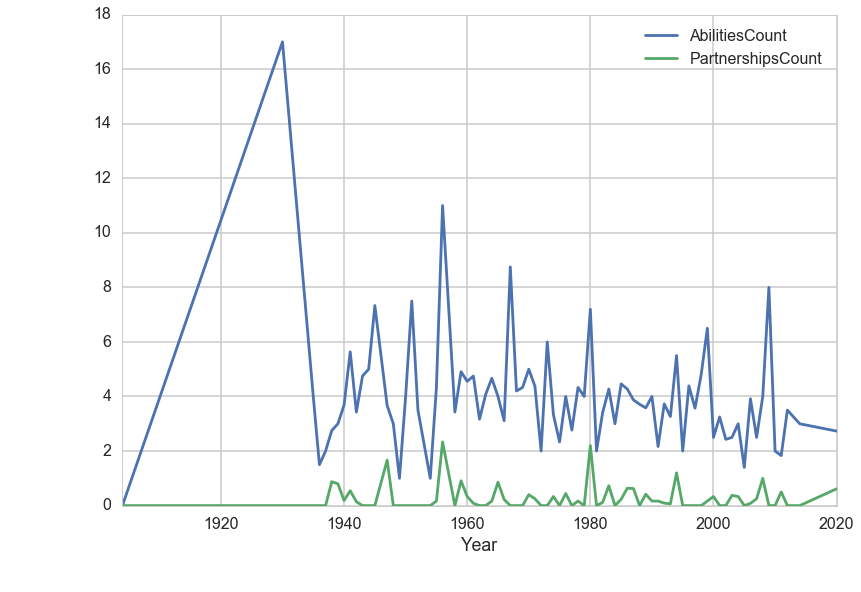

In [40]:
# docs: http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
#fig = plt.figure()
df.groupby("Year").mean().plot()
MaxValue = df['Year'].max()
plt.annotate('My Text', xy=(1000, 5),xytext=(100, 10),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),textcoords='figure points')
plt.show()
#plt.annotate('My Text', xy=(0.5, 0), xycoords='figure fraction',xytext=(0.5, 0.5), textcoords='figure fraction',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

In [41]:
df[(df.Year>=1939) & (df.Year<1945)]

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,#711,1941,Accomplished hand to hand combatant,1,NaN,0,https://en.wikipedia.org/wiki/711_(Quality_Com...,https://None,NaN
5,Air Wave,1942,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/5.jpg
11,Amazing-Man,1940,"(All),Ability to duplicate the properties of m...",8,NaN,0,https://en.wikipedia.org/wiki/Amazing-Man_(DC_...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/11.jpg
24,Aquaman,1941,"Telepathy to compel and manipulate sea life,Wa...",10,"Mera,Garth,Aquagirl,Topo",4,https://en.wikipedia.org/wiki/Aquaman,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/24.jpg
37,Atom,1940,"Atomic strength and agility,Superb athlete,Pro...",5,Atom Smasher,1,https://en.wikipedia.org/wiki/Atom_(Al_Pratt),https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/37.jpg
55,Batman,1939,"Genius-level intellect,Peak human physical and...",5,"Robin,Batgirl,Nightwing,James ""Jim"" Gordon,Cat...",8,https://en.wikipedia.org/wiki/Batman,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/55.png
56,Batman,1939,NaN,0,NaN,0,https://en.wikipedia.org/wiki/List_of_DC_Comic...,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/56.png
74,Black Condor,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Black_Condor,https://None,NaN
75,The Black Hood,1940,"(Archie/Red Circle),Great fighter,detective,(I...",6,NaN,0,https://en.wikipedia.org/wiki/Black_Hood,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/75.jpg
78,The Black Pirate,1940,Incorporeal ghost form,1,NaN,0,https://en.wikipedia.org/wiki/Black_Pirate,https://None,NaN


* Red Tornado ist "great cook"

* https://en.wikipedia.org/wiki/Onslaught_(DC_Comics) checken, interessant wegen Jihad (reiner Zufall, wäre ja jetzt eher Thema)

In [42]:
# to avoid spelling issues, we capitalize all superheroes' names
# lambda Konzept erläutern
df['NameCaps'] = df.Name.apply(lambda x: x.upper())
df['PartnershipsCaps'] = df.Partnerships.astype(str).apply(lambda x: x.upper())
df['AbilitiesCaps'] = df.Abilities.astype(str).apply(lambda x: x.upper())
df.tail()

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
552,Zatanna,1964,"Skilled,powerful user of magic",2,John Constantine,1,https://en.wikipedia.org/wiki/Zatanna,https://upload.wikimedia.org/wikipedia/en/e/ee...,./img.dc_chars/552.png,ZATANNA,JOHN CONSTANTINE,"SKILLED,POWERFUL USER OF MAGIC"
553,Zatara,1938,Can use magic by speaking the desired effect b...,1,NaN,0,https://en.wikipedia.org/wiki/Zatara,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/553.jpg,ZATARA,NAN,CAN USE MAGIC BY SPEAKING THE DESIRED EFFECT B...
554,Zauriel,1997,Access to other realms and planes of existence...,3,NaN,0,https://en.wikipedia.org/wiki/Zauriel,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/554.JPG,ZAURIEL,NAN,ACCESS TO OTHER REALMS AND PLANES OF EXISTENCE...
555,Zed,2020,"Magic,Artistry",2,NaN,0,https://en.wikipedia.org/wiki/Zed_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/555.jpg,ZED,NAN,"MAGIC,ARTISTRY"
556,Zor-El,1959,"Under a yellow sun,the same as his daughter S...",2,NaN,0,https://en.wikipedia.org/wiki/Zor-El,https://None,NaN,ZOR-EL,NAN,"UNDER A YELLOW SUN,THE SAME AS HIS DAUGHTER S..."


# LIMIT THE SIZE OF DF!

In [43]:
#df=df[(df.Year>=1970) & (df.Year<1971)]
#df

In [44]:
# create an empty graph from the nx (networkx) package imported above
G=nx.Graph()
G_abilities=nx.Graph()

# .itertuples() gives us an iterator over all rows in a data frame
for row in df.itertuples():
    hero=row[10]
    if not hero in G.nodes():
        G.add_node(hero)
        # the name attribute will be helpful for D3.js visualizations
        G.node[hero]['name'] = hero
        G.node[hero]['picture']=row[8]
        localFilePath=str(row[9])
        if not localFilePath.upper()=="NAN":
            G.node[hero]['localFilePath']=localFilePath
        else:
            G.node[hero]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below
        
    if not hero in G_abilities.nodes():
        G_abilities.add_node(hero)
        G_abilities.node[hero]['name'] = hero
        G_abilities.node[hero]['group'] = 2 # will change the display color in D3.js
        G_abilities.node[hero]['picture']=row[8]
        localFilePath=str(row[9])
        if not localFilePath.upper()=="NAN":
            G_abilities.node[hero]['localFilePath']=localFilePath
        else:
            G_abilities.node[hero]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below
        
    # treat partnerships  (PartnershipsCount)  
    if row[6]: # a shortcut to find out whether a string is empty
        if not row[11]=="NAN":
            partners=row[11].split(",")
            for partner in partners:
                if not partner in G.nodes():
                    G.add_node(partner)
                    G.node[partner]['name'] = partner
                G.add_edge(hero,partner)
    # treat abilities
    if row[4]: #AbilitiesCount
        if not row[12]=="NAN":
            abilities=row[12].split(",")
            for ab in abilities:
                if not ab in G_abilities.nodes():
                    G_abilities.add_node(ab)
                    G_abilities.node[ab]['name'] = ab
                    G_abilities.node[ab]['group'] = 1 # will change the display color in D3.js
                G_abilities.add_edge(hero,ab)
                #print "Adding edge: "+hero+" - "+str(ab)
            #G_abilities.add_edges_from(list(itertools.product(abilities,abilities))) # macht ein cross product der abilities


In [45]:
print G.number_of_nodes()
print G.number_of_edges()

582
143


In [46]:
print G_abilities.number_of_nodes()
print G_abilities.number_of_edges()

1991
2234


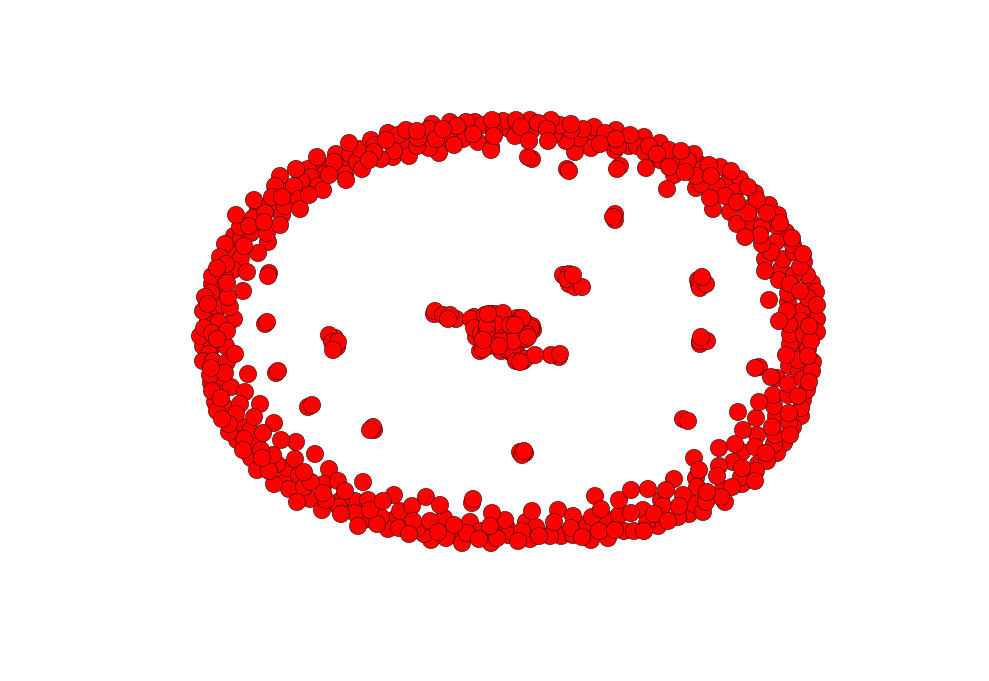

In [47]:
nx.draw_spring(G)

In [48]:
from networkx.algorithms.shortest_paths.generic import all_shortest_paths
f=all_shortest_paths(G,"BATMAN","THE JOKER")
print([p for p in f])

[['BATMAN', 'HUNTRESS (HELENA WAYNE)', u'POWER GIRL', 'HARLEY QUINN', 'THE JOKER']]


In [49]:
li=['BATMAN', 'HUNTRESS (HELENA WAYNE)', u'POWER GIRL', 'HARLEY QUINN', 'THE JOKER']

In [50]:
from networkx.algorithms.assortativity.neighbor_degree import average_neighbor_degree
average_neighbor_degree(G)

{u'#711': 0.0,
 u"'MAZING MAN": 0.0,
 u'ABIN SUR': 0.0,
 u'ACCESS': 0.0,
 u'ACE THE BAT-HOUND': 0.0,
 u'ACRATA': 2.0,
 u'ADAM STRANGE': 0.0,
 u'AGENT LIBERTY': 0.0,
 u'AIR WAVE': 0.0,
 u'ALAN SCOTT': 1.3333333333333333,
 u'ALBERT ROTHSTEIN': 2.0,
 u'ALEXANDER LUTHOR, JR.': 0.0,
 u'ALIAS THE SPIDER': 0.0,
 'ALL-AMERICAN KID': 1.0,
 u'ALLEY-KAT-ABRA': 0.0,
 u'ALPHA CENTURION': 0.0,
 u'AMAZING-MAN': 0.0,
 u'AMBUSH BUG': 0.0,
 u'AMETHYST': 0.0,
 u'ANARKY': 1.0,
 u'ANIMA': 0.0,
 u'ANIMAL MAN': 2.0,
 u'ANTAEUS': 0.0,
 'ANTI-MONITOR': 1.0,
 u'APACHE CHIEF': 3.0,
 u'AQUAGIRL': 5.0,
 u'AQUALAD': 0.0,
 'AQUAMAN': 2.4,
 u'AQUAWOMAN': 0.0,
 u'ARAK': 0.0,
 u'ARGENT': 0.0,
 u'ARGUS': 0.0,
 u'ARION': 0.0,
 u'ARISIA RRAB': 0.0,
 u'ARM FALL OFF BOY': 0.0,
 'ARSENAL': 3.5,
 'ARTEMIS': 9.0,
 u'ARTEMIS OF BANA-MIGHDALL': 8.0,
 u'ARUNA': 0.0,
 u'ATLAS': 0.0,
 u'ATMOS': 0.0,
 u'ATOM': 1.0,
 'ATOM SMASHER': 2.0,
 u'ATOMIC KNIGHT': 0.0,
 u'AURON': 0.0,
 u'AYA': 0.0,
 u'AYLA RANZZ': 0.0,
 u'AZRAEL': 0.0,
 u'AZ

In [51]:
df[df.NameCaps=="BIZARRA"]

,Name,Year,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
70,Bizarra,1984,Reverse abilities of Wonder Woman including ...,2,NaN,0,https://en.wikipedia.org/wiki/Bizarra,https://upload.wikimedia.org/wikipedia/en/thum...,./img.dc_chars/70.jpg,BIZARRA,NAN,REVERSE ABILITIES OF WONDER WOMAN INCLUDING ...


# Weitere Ideen

* mit Google nGrams abgleichen? https://books.google.com/ngrams/graph?content=Skilled%2C+magic&case_insensitive=on&year_start=1963&year_end=1965&corpus=16&smoothing=3&share=&direct_url=t4%3B%2CSkilled%3B%2Cc0%3B%2Cs0%3B%3Bskilled%3B%2Cc0%3B%3BSkilled%3B%2Cc0%3B.t4%3B%2Cmagic%3B%2Cc0%3B%2Cs0%3B%3Bmagic%3B%2Cc0%3B%3BMagic%3B%2Cc0%3B%3BMAGIC%3B%2Cc0

* x

## Using the Data in Your Website

In [52]:
import json
from networkx.readwrite import json_graph

#d = json_graph.node_link_data(G)
d = json_graph.node_link_data(G_abilities)
json.dump(d, open('./force/force.json','w'))

# weitere notwendige Files für D3.js visualization unter: /Users/david/Documents/src/javascript/visualization
# examples taken from https://github.com/networkx/networkx/tree/master/examples/javascript

# Erklärungsversuche

* The first Green Lantern character, Alan Scott, was created in 1940 during the initial popularity of superheroes. Alan Scott usually fought common criminals in New York City with the aid of his magic ring. The publication of this character ceased in 1949 during a general decline in the popularity of superhero comics, but the character saw a limited revival in later decades.

* After World War II the popularity of superheroes in general declined. The Green Lantern comic book was cancelled with issue #38 (May–June 1949), and All Star Comics #57 (1951) was the character's last Golden Age appearance. When superheroes came back in fashion in later decades, Alan Scott was revived, but was forever marginalized by the new Hal Jordan character who had been created to supplant him (see below

In [53]:
import http_server
http_server.load_url('force/force.html')

Webserver working directory: /Users/david/Documents/src/python/CulturalAnalytics
Press <RETURN> to stop server

To restart server run: 
python -m SimpleHTTPServer 8000


127.0.0.1 - - [21/Jan/2016 22:56:43] "GET /force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:43] "GET /force/force.json HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/118.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/dc_dummy.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/371.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/127.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/130.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/3.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/108.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/409.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/521.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2016 22:56:44] "GET /force/img.dc_chars/399.jpg HTTP/1.1" 200 -


* niemals "interrupt kernel" zum beenden wählen, sonst muss man das gesamte notebook shutdown machen, da der webserver sonst nicht mehr den port 8000 freigibt, zum stop immer "enter" drücken
* http_server.pyc muss gelöscht werden, wenn man etwas an http_server.py ändert